In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler , LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense , BatchNormalization , Dropout
from keras.callbacks import EarlyStopping

In [4]:
df = pd.read_csv(r"C:\datasets\SpotifyFeatures.csv")

In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [6]:
df.drop(['artist_name' , 'track_name' , 'track_id'] , axis = 1 , inplace = True)

In [7]:
numeric_col = ['acousticness' , 'danceability'	, 'duration_ms' , 'energy' , 'instrumentalness' , 'liveness' , 'loudness' , 'speechiness' , 'tempo' , 'valence']
for col in numeric_col:
    q1 = df[col].quantile(0.10)
    q3 = df[col].quantile(0.90)
    IQR = q3 - q1
    min_range = q1 - (1.5 * IQR)
    max_range = q3 + (1.5 * IQR)
    df = df[(df[col] >= (q1 - 1.5 * IQR)) & (df[col] <= (q3 + 1.5 * IQR))]

In [8]:
ss = StandardScaler()
df[['tempo' , 'duration_ms']] = ss.fit_transform(df[['tempo' , 'duration_ms']])

In [9]:
top_9_genres = df['genre'].value_counts().nlargest(9).index
df['genre'] = df['genre'].apply(lambda x: x if x in top_9_genres else 'Other')

In [10]:
df = pd.get_dummies(df , columns = ['genre' , 'mode' , 'key'] , drop_first = True)

In [11]:
le = LabelEncoder()
df['time_signature'] = le.fit_transform(df['time_signature'])

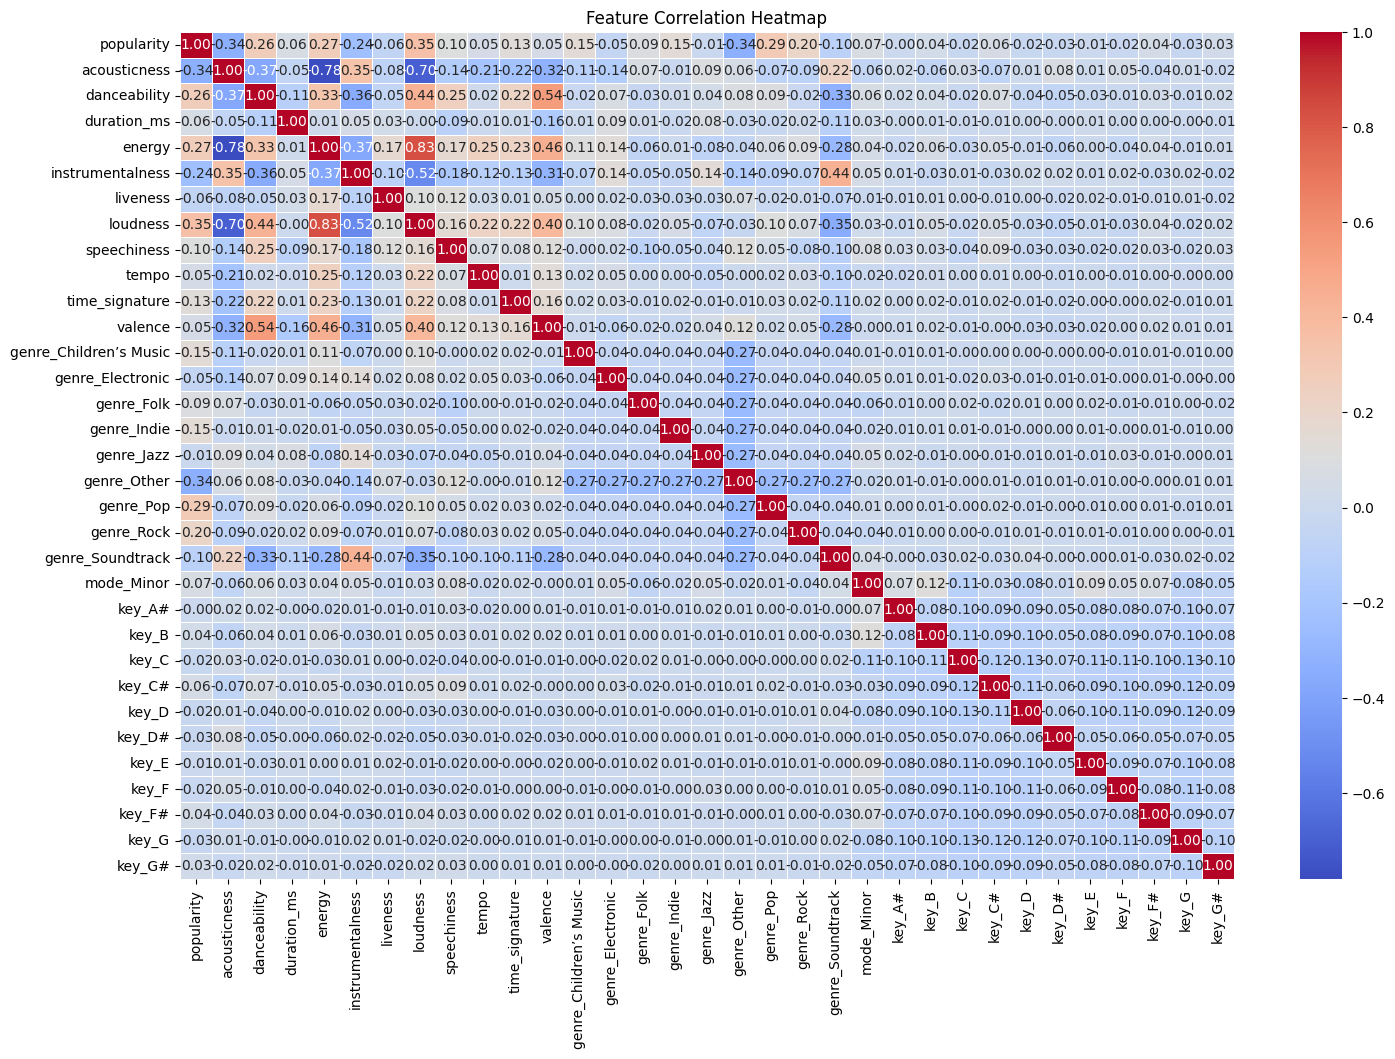

In [12]:
corr_matrix = df.corr()

plt.figure(figsize=(17, 11)) 
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

In [11]:
x = df.drop('popularity' , axis = 1)
y = df.popularity

In [12]:
x_train , x_test , y_train , y_test = train_test_split(x , y , test_size = 0.25 , random_state = True , stratify = y)

In [13]:
ann = Sequential()

ann.add(Dense(256 , activation = 'relu' , input_shape = (x_train.shape[1] , )))
ann.add(BatchNormalization())
ann.add(Dense(128 , activation = 'relu'))
ann.add(BatchNormalization())
ann.add(Dense(64 , activation = 'relu'))
ann.add(Dropout(0.2))
ann.add(Dense(32 , activation = 'relu'))
ann.add(Dropout(0.2))
ann.add(Dense(16 , activation = 'relu'))
ann.add(Dropout(0.2))
ann.add(Dense(8 , activation = 'relu'))
ann.add(Dense(1))

C:\Users\HomePC\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
ann.compile(loss = 'mean_squared_error' , optimizer = 'adam' , metrics = ['mae'])

In [15]:
early_stop = EarlyStopping(monitor = 'val_loss' , patience = 5 , restore_best_weights = True)

In [16]:
history = ann.fit(x_train , y_train , epochs = 100 , batch_size = 32 , callbacks = [early_stop] , validation_data = (x_test , y_test) , verbose = 1)

Epoch 1/100
5188/5188 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 352.1680 - mae: 14.3570 - val_loss: 269.7699 - val_mae: 13.5730
Epoch 2/100
5188/5188 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 198.3062 - mae: 10.9505 - val_loss: 248.4139 - val_mae: 12.9555
Epoch 3/100
5188/5188 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 188.6045 - mae: 10.6428 - val_loss: 257.5231 - val_mae: 13.1834
Epoch 4/100
5188/5188 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 183.3578 - mae: 10.4560 - val_loss: 239.4384 - val_mae: 12.4921
Epoch 5/100
5188/5188 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 178.3902 - mae: 10.2942 - val_loss: 258.9440 - val_mae: 12.8465
Epoch 6/100
5188/5188 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 178.8549 - mae: 10.2974 - val_loss: 239.9086 - val_mae: 12.5899
Epoch 7/100
5188/5188 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 176.8513 - mae: 10.2482 - val_loss: 235.2078 - val_mae: 12.4349
Epoch 8/100
5188/5188 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 173.2775 - mae: 10.1164 - val_loss: 276.

In [17]:
loss , accuracy = ann.evaluate(x_test , y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Mean Absolute Error : {accuracy:.4f}')

1730/1730 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 193.8488 - mae: 10.9175
Test Loss: 194.2135
Mean Absolute Error : 10.9281


In [18]:
ann.save('SpotifAI_ann_project/spotify_ann_model.h5')

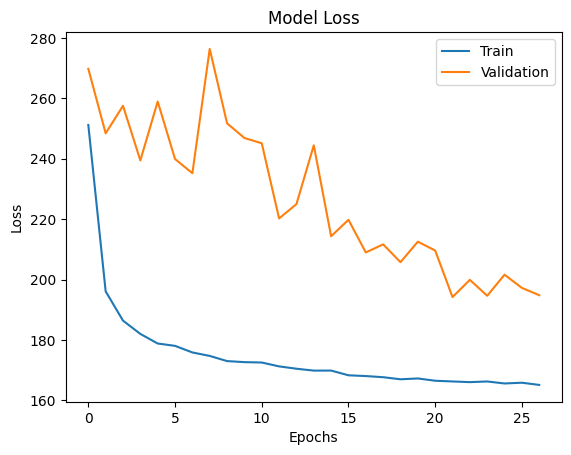

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train' , 'Validation'])
plt.show()